In [1]:
import json
import os
import random
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import einops
from nnsight import CONFIG, LanguageModel

current_dir = os.getcwd()
sys.path.append(os.path.dirname(os.path.dirname(current_dir)))
from src import env_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(10)

CONFIG.APP.REMOTE_LOGGING = True

os.environ["NDIF_KEY"] = env_utils.load_env_var("NDIF_KEY")
os.environ["HF_TOKEN"] = env_utils.load_env_var("HF_WRITE")

In [2]:
# model = LanguageModel("meta-llama/Meta-Llama-3.1-405B-Instruct")
model = LanguageModel(
    "meta-llama/Meta-Llama-3-70B-Instruct",
    cache_dir="/disk/u/nikhil/.cache/huggingface/hub/",
    device_map="auto",
    torch_dtype=torch.float16,
    dispatch=True,
)

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

# Attention heads aligning to the Answer lookback pointer subspace

In [14]:
causaltom_svs = defaultdict(dict)
for l in range(model.config.num_hidden_layers):
    causaltom_svs[l] = (
        torch.load(
            os.path.join(
                "..", "..", "svd", "causalToM", "last_token", "singular_vecs", f"{l}.pt"
            )
        )
        .half()
        .cpu()
    )

In [9]:
causaltom_mask = defaultdict(dict)
files = os.listdir(
    os.path.join(
        "..",
        "causalToM_novis",
        "results",
        "Meta-Llama-3-70B-Instruct",
        "answer_lookback",
        "pointer",
    )
)
for f in files:
    layer_idx = int(f.split(".")[0])
    causaltom_mask[layer_idx] = json.load(
        open(
            os.path.join(
                "..",
                "causalToM_novis",
                "results",
                "Meta-Llama-3-70B-Instruct",
                "answer_lookback",
                "pointer",
                f,
            )
        )
    )["singular_vector"]["metadata"]["mask"]
    causaltom_mask[layer_idx] = torch.tensor(
        causaltom_mask[layer_idx], dtype=torch.float16
    ).cpu()

In [10]:
causaltom_subspace = defaultdict(dict)
for layer_idx in range(model.config.num_hidden_layers):
    if layer_idx in causaltom_mask:
        causaltom_subspace[layer_idx] = causaltom_svs[layer_idx][
            causaltom_mask[layer_idx] == 1
        ]

In [11]:
with torch.no_grad():
    head_norms = {}
    for layer_idx in causaltom_subspace.keys():
        head_norm = torch.zeros(model.config.num_attention_heads).cpu()
        for sv in causaltom_subspace[layer_idx]:
            q_proj = model.model.layers[layer_idx].self_attn.q_proj.weight
            k_proj = model.model.layers[layer_idx].self_attn.k_proj.weight
            v_proj = model.model.layers[layer_idx].self_attn.v_proj.weight
            o_proj = model.model.layers[layer_idx].self_attn.o_proj.weight

            q_proj = q_proj / torch.norm(q_proj, dim=0)
            q_proj_sv = q_proj @ sv.to(q_proj.device)

            head_out = einops.rearrange(
                q_proj_sv,
                "(n_heads d_head) -> n_heads d_head",
                n_heads=model.config.num_attention_heads,
            )
            head_norm += torch.norm(head_out, dim=1).cpu()

        head_norms[layer_idx] = head_norm.cpu()

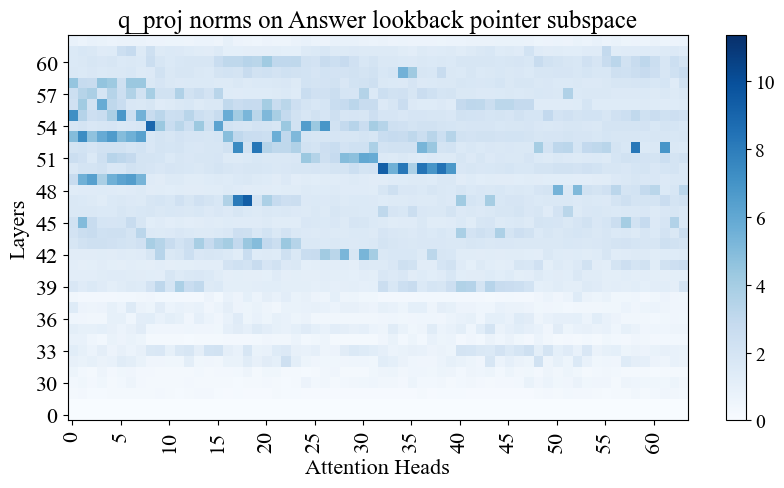

In [12]:
# Convert head_norms to a numpy array
head_norms_array = np.array(list(head_norms.values()))

# Create a heatmap of the head_norms
plt.figure(figsize=(10, 5))

# Use times new roman font
plt.rcParams["font.family"] = "Times New Roman"

# Increase the font size
plt.rcParams["font.size"] = 14

plt.imshow(
    head_norms_array,
    cmap="Blues",
    interpolation="nearest",
    aspect="auto",
    vmin=0,
    vmax=np.max(head_norms_array) + 2,
)
plt.colorbar()

plt.title("q_proj norms on Answer lookback pointer subspace", fontsize=18)

plt.xlabel("Attention Heads", fontsize=16)
plt.ylabel("Layers", fontsize=16)

plt.xticks(
    range(0, model.config.num_attention_heads, 5),
    range(0, model.config.num_attention_heads, 5),
    rotation=90,
    fontsize=16,
)
plt.yticks(
    range(0, len(head_norms.keys()), 3), list(head_norms.keys())[::3], fontsize=16
)

plt.gca().invert_yaxis()

# plt.savefig(
#     "../figures/lookback_attn_heads/answer_lookback_pointer_q_proj.pdf", dpi=300
# )
plt.show()

# Attention heads aligning in the Answer lookback payload subspace

In [ ]:
causaltom_svs = defaultdict(dict)
for l in range(model.config.num_hidden_layers):
    causaltom_svs[l] = (
        torch.load(
            os.path.join(
                "..", "..", "svd", "causalToM", "last_token", "singular_vecs", f"{l}.pt"
            )
        )
        .half()
        .cpu()
    )

In [16]:
causaltom_mask = defaultdict(dict)
files = os.listdir(
    os.path.join(
        "..",
        "causalToM_novis",
        "results",
        "Meta-Llama-3-70B-Instruct",
        "answer_lookback",
        "payload",
    )
)
for f in files:
    layer_idx = int(f.split(".")[0])
    causaltom_mask[layer_idx] = json.load(
        open(
            os.path.join(
                "..",
                "causalToM_novis",
                "results",
                "Meta-Llama-3-70B-Instruct",
                "answer_lookback",
                "payload",
                f,
            )
        )
    )["singular_vector"]["metadata"]["mask"]
    causaltom_mask[layer_idx] = torch.tensor(
        causaltom_mask[layer_idx], dtype=torch.float16
    ).cpu()

In [17]:
causaltom_subspace = defaultdict(dict)
for layer_idx in range(model.config.num_hidden_layers):
    if layer_idx in causaltom_mask:
        causaltom_subspace[layer_idx] = causaltom_svs[layer_idx][
            causaltom_mask[layer_idx] == 1
        ]

In [18]:
with torch.no_grad():
    head_norms = defaultdict(dict)
    for layer_idx in causaltom_subspace.keys():
        head_norm = torch.zeros(model.config.num_attention_heads).cpu()
        for sv in causaltom_subspace[layer_idx]:
            q_proj = model.model.layers[layer_idx].self_attn.q_proj.weight
            k_proj = model.model.layers[layer_idx].self_attn.k_proj.weight
            v_proj = model.model.layers[layer_idx].self_attn.v_proj.weight
            o_proj = model.model.layers[layer_idx].self_attn.o_proj.weight

            v_proj = v_proj / torch.norm(v_proj, dim=0)
            v_proj_sv = v_proj @ sv.to(v_proj.device)

            head_out = einops.rearrange(
                v_proj_sv,
                "(n_heads d_head) -> n_heads d_head",
                n_heads=model.config.num_attention_heads,
            )
            head_norm += torch.norm(head_out, dim=1).cpu()

        head_norms[layer_idx] = head_norm.cpu()

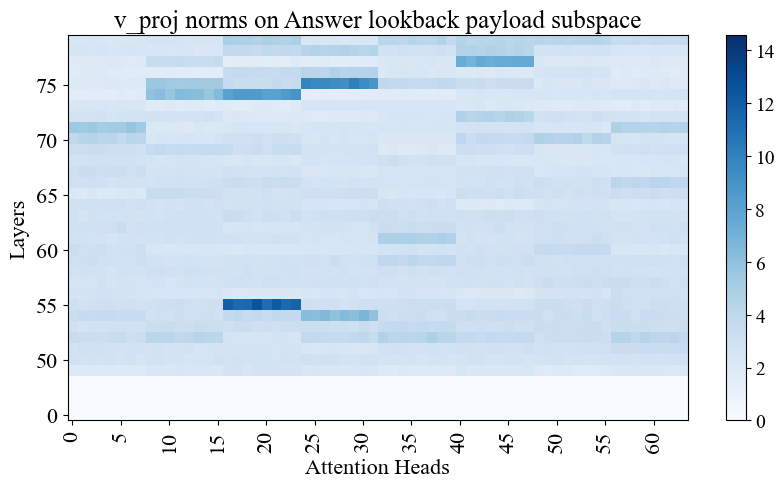

In [19]:
# Convert head_norms to a numpy array
head_norms_array = np.array(list(head_norms.values()))

# Create a heatmap of the head_norms
plt.figure(figsize=(10, 5))

# Use times new roman font
plt.rcParams["font.family"] = "Times New Roman"

# Increase the font size
plt.rcParams["font.size"] = 14

plt.imshow(
    head_norms_array,
    cmap="Blues",
    interpolation="nearest",
    aspect="auto",
    vmin=0,
    vmax=np.max(head_norms_array) + 2,
)
plt.colorbar()

plt.title("v_proj norms on Answer lookback payload subspace", fontsize=18)

plt.xlabel("Attention Heads", fontsize=16)
plt.ylabel("Layers", fontsize=16)

plt.xticks(
    range(0, model.config.num_attention_heads, 5),
    range(0, model.config.num_attention_heads, 5),
    rotation=90,
    fontsize=16,
)
plt.yticks(
    range(0, len(head_norms.keys()), 5), list(head_norms.keys())[::5], fontsize=16
)
plt.gca().invert_yaxis()

# plt.savefig(
#     "../figures/lookback_attn_heads/answer_lookback_payload_v_proj.pdf", dpi=300
# )
plt.show()